# Demo de implementación de un algoritmo de  Hormigas (Ant Colony System) para resolver el Problema del Vendedor Viajero (o TSP) y encontrar el mejor camino para unir varios puntos
Basado en la librería https://github.com/guofei9987/scikit-opt explicada en https://medium.com/@sakamoto2000.kim/ant-colony-optimization-aco-in-the-travel-salesman-problem-tsp-54f83ccd9eff

In [1]:
#@title Instalar librerías
# -@title Instalar Librería (no hace falta)
##!pip install scikit-opt
print("No se instala la librería porque no se necesita")

No se instala la librería porque no se necesita


In [2]:
#@title Cargar librerías
from __future__ import division
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib as mpl
from matplotlib import cm
import copy

##from sko.ACA import ACA_TSP

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title PARÁMETROS

#@markdown Parámetros del Espacio de búsqueda para TSP:

CANT_POSICIONES = 10 #@param {type:"slider", min:3, max:25, step:1}
if CANT_POSICIONES < 3:
  CANT_POSICIONES = 3

MIN_ESPACIO_BUSQ = 0 #@param {type:"slider", min:-100, max:0, step:5}
MAX_ESPACIO_BUSQ = 100  #@param {type:"slider", min:0, max:100, step:5}


print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar los objetos Hormiga y Mapa de Búsqueda con la  Función Heurística:

In [4]:
posDefinidas = []
defPosicionesManual = True #@param {type:"boolean"}
#@markdown Nota: si no marca esta opción el grafo se genera en forma aleatoria.

if defPosicionesManual:
  # indicar las posiciones (x, y)
  # que corresponden
  # a cada uno de los puntos a unir
  posDefinidas.append( [1, 1])
  posDefinidas.append( [100, 1])
  posDefinidas.append( [1, 100])
  posDefinidas.append( [100, 100])
  posDefinidas.append( [50, 50])
  posDefinidas.append( [5, 50])
  posDefinidas.append( [50, 5])


Clase Mapa de Búqueda definida TSP

Mapa de búsqueda TSP definido

## Posiciones generadas:  7
   A --> [1, 1]
   B --> [100, 1]
   C --> [1, 100]
   D --> [100, 100]
   E --> [50, 50]
   F --> [5, 50]
   G --> [50, 5]


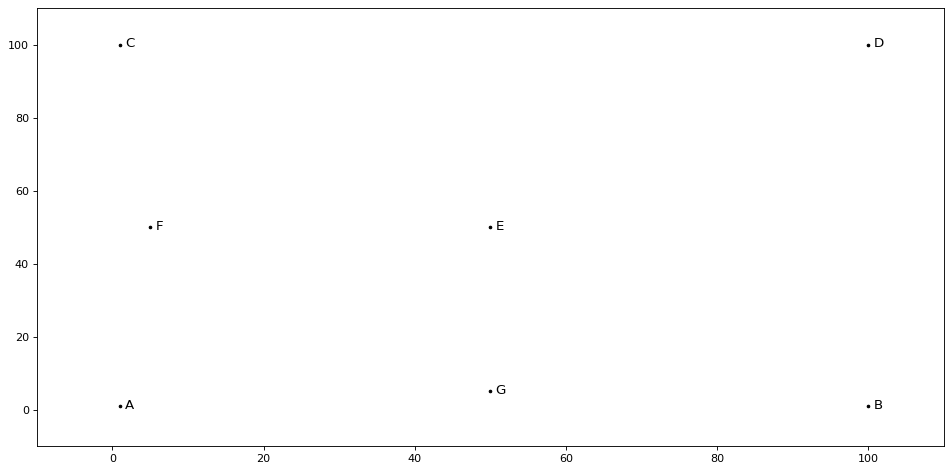


## Matriz de Distancias: 
         A        B        C        D       E        F        G
A    0.000   99.000   99.000  140.007  69.296   49.163   49.163
B   99.000    0.000  140.007   99.000  70.007  106.892   50.160
C   99.000  140.007    0.000   99.000  70.007   50.160  106.892
D  140.007   99.000   99.000    0.000  70.711  107.355  107.355
E   69.296   70.007   70.007   70.711   0.000   45.000   45.000
F   49.163  106.892   50.160  107.355  45.000    0.000   63.640
G   49.163   50.160  106.892  107.355  45.000   63.640    0.000

 - Distancia promedio:  83.0  --> Total promedio:  579.0




In [5]:
#@title clase MAPA DE BÚSQUEDA TSP

class MapaBusquedaTSP(object):

    def __init__(self, limMin=-100, limMax=100, posiciones=[], cantPosiciones=10):
          self.limMin = limMin
          self.limMax = limMax
          if (posiciones is None) or (len(posiciones) < 2):
            # genera posiciones al azar
            if cantPosiciones > 2:
              self.cantidadPosiciones = cantPosiciones
            else:
              self.cantidadPosiciones = 2
            self.generarPosicionesRnd( self.cantidadPosiciones)
          else:
            # usa las posiciones indicadas
            self.posiciones = copy.deepcopy(posiciones)
            self.cantidadPosiciones = len(self.posiciones)
          # calcula la matriz de distancia
          self.matrizDistancia = spatial.distance.cdist(self.posiciones, self.posiciones, metric='euclidean')
          self.maxDistanciaPenalizar = np.max(  self.matrizDistancia ) + 1

    def generarPosicionesRnd(self, cantPosiciones):
        # Define las posiciones al azar
        self.posiciones = []
        for i in range(cantPosiciones):
          auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]
          self.posiciones.append( auxPos )
        return True

    def formateaIdPosicion(self, idPos):
        return chr(idPos+65)

    def formateaListaPosiciones(self, posList):
      auxRes = ""
      for id in posList:
        auxRes = auxRes + self.formateaIdPosicion(id) + " - "
      return auxRes[:len(auxRes)-2]

    def mostrarMatriz(self, matriz, titulo=""):
        print("\n"+titulo)
        cmd = pd.DataFrame(
            np.round(matriz, decimals=3),
            index=["  "+self.formateaIdPosicion(x) for x in range(self.cantidadPosiciones)],
            columns=[self.formateaIdPosicion(x) for x in range(self.cantidadPosiciones)]
          )
        # agrega para poder mostrar la matrix completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmd)
        return

    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda

        ## muesta las posiciones generadas
        print("\n## Posiciones generadas: ", self.cantidadPosiciones)
        i = 0
        for auxPos in self.posiciones:
            print("  ", self.formateaIdPosicion(i),"-->", auxPos)
            i = i + 1
        # muestra gráfico con
        self.graficar(True)

        # muestra la matriz de distancia
        self.mostrarMatriz(self.matrizDistancia, "## Matriz de Distancias: ")
        # calcula distancia promedio
        filter_arr = self.matrizDistancia > 0
        distAvg = np.mean( self.matrizDistancia[filter_arr] )
        print("\n - Distancia promedio: ", round(distAvg, 0), " --> Total promedio: ", round(distAvg*self.cantidadPosiciones, 0))
        print("\n")
        return

    # Definir posiciones de un recorrido
    def devPosicionesRecorrido(self, recorrido, agregaPrimeroFinal=True):
      # determina el recorrido
      coordX = []
      coordY = []
      for r in recorrido:
        pos = self.posiciones[r]
        coordX.append( pos[0] )
        coordY.append( pos[1] )
      if agregaPrimeroFinal:
        # agrega al final la posición original para que cierre el circuito
        pos = self.posiciones[ recorrido[0] ]
        coordX.append( pos[0] )
        coordY.append( pos[1] )
      return coordX, coordY

    def graficar(self, mostrar=True, ax=None):
      if ax is None:
        fig = plt.figure(figsize=(12,6), dpi=80)
        ax = fig.add_subplot(111)
      else:
        fig = ax.figure
      ax.axis([self.limMin-10, self.limMax+10, self.limMin-10, self.limMax+10])
      # muesta posiciones en el gráfico
      i = 0
      for auxPos in self.posiciones:
          ax.scatter(auxPos[0], auxPos[1], color="black", s=5)
          ax.annotate(self.formateaIdPosicion(i), (auxPos[0]+0.7, auxPos[1]-0.7), fontsize=12)
          i = i + 1
      if mostrar:
        plt.tight_layout()
        plt.show()
      return fig, ax

    def calculaDistanciaTotal(self, routine):
        num_points, = routine.shape
        return sum([self.matrizDistancia[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])


print("\nClase Mapa de Búqueda definida TSP")

# Define el Mapa de Búsqueda
mapa = MapaBusquedaTSP(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    posiciones=posDefinidas,
                    cantPosiciones=CANT_POSICIONES)

print("\nMapa de búsqueda TSP definido")

# Muestra su información
mapa.printInformacion()

In [6]:
#@title clase HORMIGAS TSP

# clase copiada de https://github.com/guofei9987/scikit-opt/blob/dd420238b863ce8abecf3db0f5815a6602eecb1b/sko/ACA.py
# se traducen algunos comentarios y se agregan unos retoques para mejorar la visualización de los resultados
# (por ejemplo self.generation_Tau para guardar histórico de feromonas)

class ACA_TSP:
    def __init__(self, func, n_dim,
                 size_pop=10, max_iter=20,
                 distance_matrix=None,
                 alpha=1, beta=2, rho=0.1,
                 ):
        self.func = func # función heurística
        self.n_dim = n_dim  # numero de puntos
        self.size_pop = size_pop  # cantidad de hormigas
        self.max_iter = max_iter  # número de iteraciones
        self.alpha = alpha  # Importancia de las feromonas
        self.beta = beta  # La importancia de la heuristica
        self.rho = rho  # Tasa de volatilización de feromonas
        self.prob_matrix_distance = 1 / (distance_matrix + 1e-10 * np.eye(n_dim, n_dim))  # 避免除零错误
        # Matriz de feromonas, actualizada cada iteración
        self.Tau = np.ones((n_dim, n_dim))
        # El camino de rastreo de cada hormiga en una determinada generación.
        self.Table = np.zeros((size_pop, n_dim)).astype(np.int_)  # 某一代每个蚂蚁的爬行路径
        # la distancia total de rastreo de cada hormiga en una determinada generación.
        self.y = None  # 某一代每个蚂蚁的爬行总距离
        # Documentando lo mejor de las generaciones.
        self.generation_best_X, self.generation_best_Y = [], []  # 记录各代的最佳情况
        self.generation_Tau = [] # histórico de fermonoas
        self.x_best_history, self.y_best_history = self.generation_best_X, self.generation_best_Y  # 历史原因，为了保持统一
        self.best_x, self.best_y = None, None

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):  # 对每次迭代
            prob_matrix = (self.Tau ** self.alpha) * (self.prob_matrix_distance) ** self.beta  # 转移概率，无须归一化。
            for j in range(self.size_pop):  # 对每个蚂蚁
                self.Table[j, 0] = 0  # start point，其实可以随机，但没什么区别
                for k in range(self.n_dim - 1):  # 蚂蚁到达的每个节点
                    taboo_set = set(self.Table[j, :k + 1])  # 已经经过的点和当前点，不能再次经过
                    allow_list = list(set(range(self.n_dim)) - taboo_set)  # 在这些点中做选择
                    prob = prob_matrix[self.Table[j, k], allow_list]
                    prob = prob / prob.sum()  # 概率归一化
                    next_point = np.random.choice(allow_list, size=1, p=prob)[0]
                    self.Table[j, k + 1] = next_point

            # 计算距离
            y = np.array([self.func(i) for i in self.Table])

            # 顺便记录历史最好情况
            index_best = y.argmin()
            x_best, y_best = self.Table[index_best, :].copy(), y[index_best].copy()
            self.generation_best_X.append(x_best)
            self.generation_best_Y.append(y_best)

            # 计算需要新涂抹的信息素 - actualización de feromonas
            delta_tau = np.zeros((self.n_dim, self.n_dim))
            for j in range(self.size_pop):  # 每个蚂蚁
                for k in range(self.n_dim - 1):  # 每个节点
                    n1, n2 = self.Table[j, k], self.Table[j, k + 1]  # 蚂蚁从n1节点爬到n2节点
                    delta_tau[n1, n2] += 1 / y[j]  # 涂抹的信息素
                n1, n2 = self.Table[j, self.n_dim - 1], self.Table[j, 0]  # 蚂蚁从最后一个节点爬回到第一个节点
                delta_tau[n1, n2] += 1 / y[j]  # 涂抹信息素

            # 信息素飘散+信息素涂抹
            self.Tau = (1 - self.rho) * self.Tau + delta_tau
            self.generation_Tau.append( copy.deepcopy( self.Tau ) )

        best_generation = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[best_generation]
        self.best_y = self.generation_best_Y[best_generation]
        return self.best_x, self.best_y

    fit = run

print("Clase Hormigas ACA_TSP definida.")

Clase Hormigas ACA_TSP definida.


4) Ejecutar la corrida del algoritmo mostrando resultados:

== Mejor Recorrido de la Corrida {461.493}: A - F - C - D - B - E - G  == 



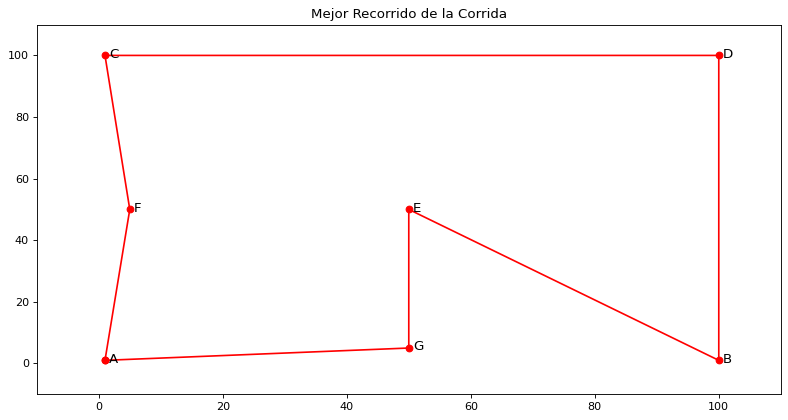




** Recorrido según Feromonas Final {463.193}: A - F - C - D - E - G - B - A  **



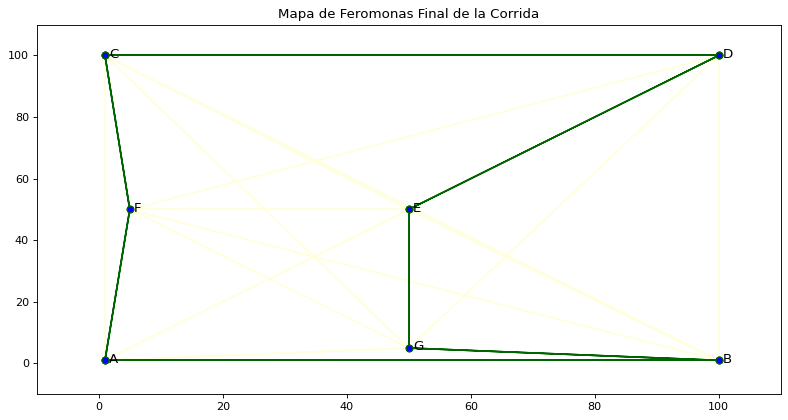


## Matriz de Feromonas Final: 
       A      B      C      D      E      F      G
A  0.000  0.000  0.000  0.000  0.000  0.022  0.000
B  0.022  0.000  0.000  0.000  0.000  0.000  0.000
C  0.000  0.000  0.000  0.022  0.000  0.000  0.000
D  0.000  0.000  0.000  0.000  0.022  0.000  0.000
E  0.000  0.000  0.000  0.000  0.000  0.000  0.022
F  0.000  0.000  0.022  0.000  0.000  0.000  0.000
G  0.000  0.022  0.000  0.000  0.000  0.000  0.000


In [7]:
#@title EJECUCIÓN DE LA CORRIDA

#@markdown Parámetros del Algoritmo de Hormigas:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 30 #@param {type:"integer"}

# Configuración de las Hormigas
CANT_HORMIGAS = 5 #@param {type:"slider", min:1, max:10, step:1}

# Parámetros de Atracción
ATRACCION_FEROMONAS = 1.5 #@param {type:"slider", min:0, max:10, step:0.1}
ATRACCION_HEURISTICA = 2 #@param {type:"slider", min:0, max:10, step:0.1}
EVAPORACION_FEROMONAS = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.05}


# define función heurística a minimizar
# considerando el problema TSP a resolver y el recorrido a realizar
def funcCostoTSP(routine):
  global mapa
  # calcula la distancia total del recorrido
  res = mapa.calculaDistanciaTotal(routine)
  # penaliza si hay puntos por los que no pasa
  # y/o si hay puntos pasa más de una vez
  routine = list(routine)
  for i in range(mapa.cantidadPosiciones):
    cantI = routine.count(i) - 1
    if cantI < 0:
      # penaliza por falta punto
      res = res + mapa.maxDistanciaPenalizar
    elif cantI > 0:
      # no es el primero y último
      if not((routine[0] == i) and (routine[-1] == i)):
        # penaliza por cada ocurrencia repetida
        res = res + mapa.maxDistanciaPenalizar * cantI
  # devuelve costo
  return res

# Prepara para la corrida
aca = ACA_TSP(func=funcCostoTSP, n_dim=mapa.cantidadPosiciones,
                size_pop=CANT_HORMIGAS, max_iter=CANT_CICLOS,
                distance_matrix=mapa.matrizDistancia,
                alpha=ATRACCION_FEROMONAS,
                beta=ATRACCION_HEURISTICA,
                rho=EVAPORACION_FEROMONAS)

# Ejecuta la corrida
mejorRecorrido, mejorCosto = aca.run()

# nota:
#  aca.Tau: guarda el estado de las feromonas
#  aca.prob_matrix_distance: guarda las "heurísticas" de cada nodo de acuerdo a la matriz de distancia
msgMejor = "== Mejor Recorrido de la Corrida {" + str(round(mejorCosto, 3)) + "}: "+ str(mapa.formateaListaPosiciones(mejorRecorrido)) + " =="
print(msgMejor, "\n")

# Muesta el gráfico del Mejor Recorrido
fig, ax = mapa.graficar(mostrar=False)
# determina el recorrido
# Determina las coordenadas x, y de las posiciones en el mejor recorrido
X, Y = mapa.devPosicionesRecorrido( mejorRecorrido )
# muesta el recorrido
ax.plot(X, Y, 'o-r')
ax.set_title("Mejor Recorrido de la Corrida")
#plt.tight_layout()
plt.show()

# Muestra el Gráfico de Matriz de Feromonas Final
print("\n")
# método que se usa para generar gradiente de colores
def colorFader(c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def mostrarFeromonas(axFer, matFeromonas):
    auxVecFer = []
    maxFer = np.max(matFeromonas)
    # determina valor relativo a mostrar
    for p1 in range(mapa.cantidadPosiciones):
      for p2 in range(mapa.cantidadPosiciones):
        if p1 < p2:
            valRel = max(matFeromonas[p1][p2], matFeromonas[p2][p1]) / maxFer
            X, Y = mapa.devPosicionesRecorrido( [p1, p2] )
            auxVecFer.append( [valRel, X, Y] )
    # ordena de menor a mayor para que se vean mejor las líneas con gran valor
    auxVecFer = sorted(auxVecFer, key=lambda k: k[0], reverse=False)
    # muestra las líneas de feromonas
    for vFer in auxVecFer:
      c = colorFader('lightyellow', 'darkgreen', vFer[0])
      lineFer = axFer.plot(vFer[1], vFer[2],
                  marker='o', markerfacecolor='b', color=c, linestyle='-')
    return


# calcula el recorrido según feromonas
def recorridoFeromonas(matTau):
    p = 0
    rec_list = [0]
    while True:
      p = np.argmax(matTau[p])
      rec_list.append( p )
      if p == 0:
        break
    rec_list = np.array(rec_list)
    ##dist = mapa.calculaDistanciaTotal( rec_list )
    costo = funcCostoTSP( rec_list )
    return rec_list, costo

fer_rec, fer_costo = recorridoFeromonas(aca.Tau)
print("\n** Recorrido según Feromonas Final {" + str(round(fer_costo, 3)) + "}: "+ str(mapa.formateaListaPosiciones(fer_rec)) + " **\n" )

figFer, axFer = mapa.graficar(mostrar=False)
axFer.set_title("Mapa de Feromonas Final de la Corrida")
mostrarFeromonas(axFer, aca.Tau)
#plt.tight_layout()
plt.show()
mapa.mostrarMatriz(aca.Tau, "## Matriz de Feromonas Final: ")


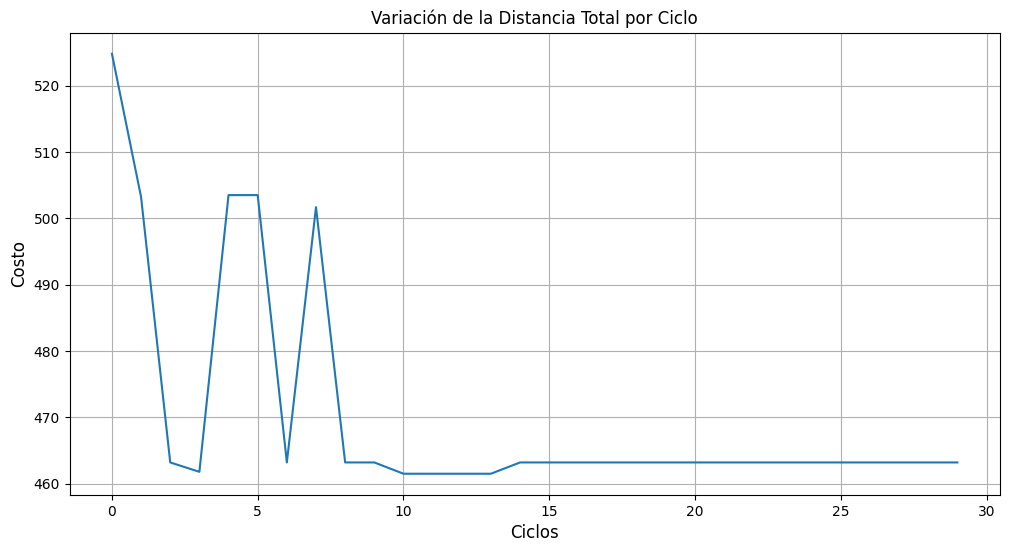

In [8]:
#@title MOSTRAR VARIACIÓN DE LA DISTANCIA
plt.figure(figsize=(12,6))
plt.plot(aca.y_best_history)
plt.title('Variación de la Distancia Total por Ciclo')
plt.xlabel('Ciclos', fontsize=12)
plt.ylabel('Costo', fontsize=12)
plt.grid(True)
plt.show()

In [9]:
#@title MOSTRAR GRAFICO MEJOR RECORRIDO + FEROMINAS POR CADA CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# inicializa variables auxiliares
recCiclo = aca.x_best_history
distCiclo = aca.y_best_history
matFeromonasCiclo = aca.generation_Tau

# Método que se ejecuta por cada frame para mostrar
def updatePlot(i):
    i = i - 1 # le resta 1 para que arranque vacío
    if i < 0:
        axFer.set_xlabel("Ciclo: 0", fontsize=12)
        # muestra gráfico de feromonas inicial
        lineFer = mostrarFeromonas(axFer, matFeromonasCiclo[0])
    else:
      # muestra gráfico de feromonas actual
      if i<len(matFeromonasCiclo):
        lineFer = mostrarFeromonas(axFer, matFeromonasCiclo[i])
      # muestra gráfico de recorrido actual
      if i<len(recCiclo):
        distMostrar = str(round(distCiclo[i], 3))
        if distCiclo[i] == mejorCosto:
          distMostrar = distMostrar + "!"
          colorLineRec = 'r'
        else:
          colorLineRec = 'c'
        axFer.set_xlabel("Ciclo: " + str(i+1) + " - Costo Recorrido: " + distMostrar, fontsize=12)
        # Determina las coordenadas x, y del recorrido 'i'
        X, Y = mapa.devPosicionesRecorrido( recCiclo[i] )
        plt.setp(lineRec, 'xdata', X, 'ydata', Y)
        plt.setp(lineRec, 'color', colorLineRec)
      else:
        axFer.set_xlabel("Ciclo: " + str(i+1), fontsize=12)
    return lineRec

def prepararAxFig(nfig, posSubPlot=111):
  # crea subplot
  dummy_ax = nfig.add_subplot(posSubPlot)
   # prepara el gráfico base (puntos)
  figBase, ax = mapa.graficar(mostrar=False, ax=dummy_ax)
  return ax

# prepara gráfico para animación
fig = plt.figure(figsize=(12,6), dpi=80)
# indica gráfico para recorrido
axRec = prepararAxFig(fig, 211)
axRec.set_xticklabels([])
# segundo gráfico para feromonas
axFer = prepararAxFig(fig, 212)
plt.close(fig)
plt.close(fig)

# Determina las coordenadas x, y de las posiciones en el recorrido inicial
# (las marca en blanco para que no se vean)
X, Y = mapa.devPosicionesRecorrido( recCiclo[0] )
lineRec = axRec.plot(X, Y,
            marker='o', markerfacecolor='b', color='w', linestyle='-')
lineFer = []
# Muestra título y texto debajo
axRec.set_title("Mejor Recorrido por Ciclo")
axFer.set_title("Mapa de Fermonas por Ciclo")

# Luego setea la animación usando los dos métodos anteriores
cant = len(recCiclo)+1  # le suma 1 porque arranca vacío
ani = animation.FuncAnimation(fig, updatePlot,
                              frames=cant, interval=cant,
                              blit=True, repeat=False)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)

print("\n", msgMejor)


 == Mejor Recorrido de la Corrida {461.493}: A - F - C - D - B - E - G  ==
